# Import all modules

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
from matplotlib import pyplot as plt

# Set no of years

years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

# Tickers we want to incorporate in our portfolio
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

# Create an empty df to store all close prices from yahoo finance 
close_df = pd.DataFrame()



# Download all tickers data from yahoo finance and add it to the empty dataframe created above

In [2]:
for ticker in tickers:
    data = yf.download(ticker, start= startDate, end = endDate)
    close_df[ticker] = data['Close']



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Compute Log Returns 

In [3]:
log_returns = np.log(close_df/close_df.shift(1))
log_returns = log_returns.dropna()


# Create a fn to calc Portfolio Expected Return

In [4]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

# Create a fn to calc Portfolio Stdev

In [5]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Create a covariance matrix for all the securities

In [6]:
cov_matrix = log_returns.cov()
print(cov_matrix)

              SPY           BND       GLD       QQQ           VTI
SPY  1.215912e-04  4.425425e-07  0.000005  0.000136  1.238975e-04
BND  4.425425e-07  9.531347e-06  0.000009  0.000001  6.367490e-07
GLD  5.403966e-06  9.026279e-06  0.000096  0.000007  5.939923e-06
QQQ  1.357196e-04  1.254335e-06  0.000007  0.000174  1.383198e-04
VTI  1.238975e-04  6.367490e-07  0.000006  0.000138  1.272357e-04


# Create an equally weighted portofolio and find total portfolio expected return

In [7]:
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
portolio_expected_return = expected_return(weights, log_returns)
portfolio_std_dev = standard_deviation(weights, cov_matrix)

print(portolio_expected_return)


0.00038996416711628264


# Create a function to that gives a random Z-score based on normal dist. 
We do this because we'll be doing 10000 simulations, and each simulation will generate a random z score.

In [8]:
def random_z_score():
    return np.random.normal(0,1)

# Create a function to calculate Scenario Gain Loss

In [9]:
days = 30  # After n days, what is the VaR, for a given confidence interval?

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return (portfolio_value * portolio_expected_return * days) + (portfolio_value * portfolio_std_dev * z_score * np.sqrt(days))  # First bracket captures portfolio return and 2nd bracket captures portfolio volatility.
                                                                                                                                # Since we're using z-score, 2nd bracket can be positive or negative 

# Run 10000 simulations

In [10]:
simulations = 10000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

# Specify a confidence interval and calculate the Value at Risk 

In [11]:
confidence_interval = 0.99
VaR = - np.percentile(scenarioReturn, 100*(1-confidence_interval))
print(VaR)
print(f"{(VaR/portfolio_value):.2%}")

81274.51331341105
8.13%


# Plot the results of all 10000 scenarios

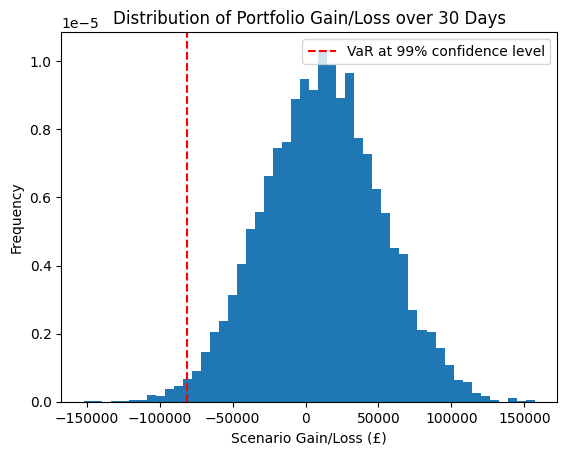

In [12]:
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss (£)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss over {days} Days')
plt.axvline(-VaR, color='r', linestyle='dashed', label=f'VaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()

# CVAR 

In [13]:
def calculate_cvar(scenarioReturn, confidence_level=0.95):

    # Convert to numpy array for easier manipulation
    losses = np.array(scenarioReturn)
    
    # Sort the losses in ascending order (most negative first)
    sorted_losses = np.sort(losses)
    
    # Calculate the index for the confidence level
    var_index = int((1 - confidence_level) * len(sorted_losses))
    
    # Calculate CVaR as the average of the worst losses
    cvar = -np.mean(sorted_losses[:var_index])
    
    return cvar

cVaR = calculate_cvar(scenarioReturn, confidence_level=confidence_interval)
print(cVaR)

95716.60061026998


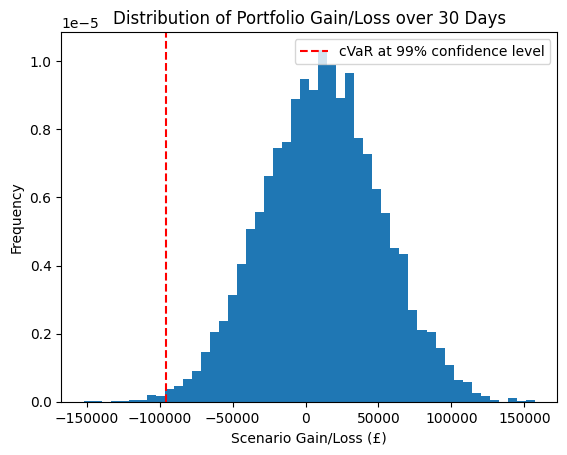

In [14]:
plt.hist(scenarioReturn, bins=50, density=True)
plt.xlabel('Scenario Gain/Loss (£)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/Loss over {days} Days')
plt.axvline(-cVaR, color='r', linestyle='dashed', label=f'cVaR at {confidence_interval:.0%} confidence level')
plt.legend()
plt.show()